## Loading the data

In [64]:
import numpy as np
import scanpy as sc
import scvelo as scl
import os 

sc.set_figure_params(dpi=100, frameon=False)
sc.logging.print_header()

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.2 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 leidenalg==0.8.3


In [2]:
os.getcwd()

'/home/mo/projects/test_AdvAE/Norman_results'

In [3]:
os.chdir("../")

In [4]:
adata = sc.read('./datasets/Norman2019_prep_new.h5ad')

In [5]:
import torch
from compert.train import prepare_compert

state, args, metrics = torch.load('./pretrained_models/Norman2019_prep_new_deg_collect/relu/sweep_Norman2019_prep_new_relu_split21_model_seed=16_epoch=80.pt', map_location=torch.device('cuda'))
args['dataset_path'] = './datasets/Norman2019_prep_new.h5ad'
args['save_dir'] = '/ckpts'
# load the dataset and model pre-trained weights
model, datasets = prepare_compert(args, state_dict=state)

In [6]:
args

{'dataset_path': './datasets/Norman2019_prep_new.h5ad',
 'perturbation_key': 'condition',
 'dose_key': 'dose_val',
 'cell_type_key': 'cell_type',
 'split_key': 'split21',
 'loss_ae': 'gauss',
 'doser_type': 'linear',
 'decoder_activation': 'ReLU',
 'seed': 16,
 'hparams': '',
 'max_epochs': 2000,
 'max_minutes': 300,
 'patience': 20,
 'checkpoint_freq': 20,
 'save_dir': '/ckpts',
 'sweep_seeds': 200}

Currently we need to provide the whole dataset to initialize the API. Parameter 'return_dataset=True' in load_dataset_splits() will return this full dataset in the correct format.

In [7]:
%%time
from compert.data import load_dataset_splits

datasets, full_dataset = load_dataset_splits(  
    dataset_path=args['dataset_path'],
    perturbation_key=args['perturbation_key'],
    dose_key=args['dose_key'],
    cell_type_key=args['cell_type_key'],
    split_key = args["split_key"],
    return_dataset=True)  

CPU times: user 39 s, sys: 2.16 s, total: 41.1 s
Wall time: 38.2 s


In [8]:
from compert.plotting import CompertVisuals
from compert.api import ComPertAPI

In [9]:
compert_api = ComPertAPI(datasets, model)

####  Predicition 

In [10]:
adata.var_names = adata.var.gene_symbols

In [11]:
import seaborn as sns

In [12]:
np.random.seed(0)
sns.set_style("whitegrid")

In [13]:
adata_ood = adata[adata.obs["split21"] == "ood"]

In [14]:
adata_ood.obs["condition"].value_counts()

UBASH3B+OSR2     796
DUSP9+ETS2       787
MAPK1+TGFBR2     497
AHR+KLF1         481
KLF1+CEBPA       311
TGFBR2+IGDCC3    301
MAP2K6+IKZF3     300
TGFBR2+PRTG      265
ZC3HAV1+CEBPA     86
Name: condition, dtype: int64

In [20]:
condition_key = "condition"

In [21]:
ood = ["DUSP9+ETS2"]

In [22]:
torch.random.seed = 300

In [23]:
import pandas as pd

In [25]:
genes_control = full_dataset.genes[full_dataset.indices['control']]
perm = torch.randperm(genes_control.size(0),)
idx = perm[:500]
ss_ctrl = genes_control[idx]
df = pd.DataFrame({args['perturbation_key']: ood, 
                   args['dose_key']: ['1+1'] *len(ood), 
                   args['cell_type_key']: ['A549']*len(ood)})
predicted_data = compert_api.predict(ss_ctrl, df, return_anndata=True)

In [26]:
predicted_data.obs[condition_key] = "pred_" + predicted_data.obs[condition_key]

In [27]:
predicted_data.obs["condition"].value_counts()


pred_DUSP9+ETS2    500
Name: condition, dtype: int64

In [41]:
single = ["DUSP9+ctrl","ctrl","ETS2+ctrl"]

In [42]:
single_ood = adata[adata.obs[condition_key].isin(single)]

In [44]:
single_ood.obs.condition.value_counts()

ctrl          8907
DUSP9+ctrl     731
ETS2+ctrl      451
Name: condition, dtype: int64

In [45]:
all_adata = single_ood.concatenate(adata_ood)

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [46]:
predicted_data.var_names = adata.var_names

In [47]:
all_adata = all_adata.concatenate(sc.AnnData(predicted_data))

In [48]:
all_adata.obs["condition"].value_counts()

ctrl               8907
UBASH3B+OSR2        796
DUSP9+ETS2          787
DUSP9+ctrl          731
pred_DUSP9+ETS2     500
MAPK1+TGFBR2        497
AHR+KLF1            481
ETS2+ctrl           451
KLF1+CEBPA          311
TGFBR2+IGDCC3       301
MAP2K6+IKZF3        300
TGFBR2+PRTG         265
ZC3HAV1+CEBPA        86
Name: condition, dtype: int64

## DUSP9+ETS2

In [49]:
to_select = ["ctrl","DUSP9+ctrl","ETS2+ctrl","pred_DUSP9+ETS2","DUSP9+ETS2"]

In [50]:
story_1 = all_adata[all_adata.obs[condition_key].isin(to_select)]

In [51]:
story_1.obs[condition_key].value_counts()


ctrl               8907
DUSP9+ETS2          787
DUSP9+ctrl          731
pred_DUSP9+ETS2     500
ETS2+ctrl           451
Name: condition, dtype: int64

In [52]:
ctrl = story_1[story_1.obs[condition_key] == to_select[0]]
ctrl.obs["order"] = np.linspace(0,0.1, num=len(ctrl))
dusp_ctrl = story_1[story_1.obs[condition_key] == to_select[1]]
dusp_ctrl.obs["order"] = np.linspace(.11,0.2, num=len(dusp_ctrl))
pred_DUSP9_MAPK1 = story_1[story_1.obs[condition_key] == to_select[2]]
pred_DUSP9_MAPK1.obs["order"] = np.linspace(.21,0.4, num=len(pred_DUSP9_MAPK1))
dusp_map = story_1[story_1.obs[condition_key] == to_select[3]]
dusp_map.obs["order"] = np.linspace(0.41,0.5, num=len(dusp_map))
ctrl_mapk1 = story_1[story_1.obs[condition_key] == to_select[4]]
ctrl_mapk1.obs["order"] = np.linspace(.51,0.6, num=len(ctrl_mapk1))
story_1 = sc.AnnData.concatenate(ctrl,ctrl_mapk1,dusp_ctrl,pred_DUSP9_MAPK1,dusp_map)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [53]:
story_1.obs[condition_key].value_counts()


ctrl               8907
DUSP9+ETS2          787
DUSP9+ctrl          731
pred_DUSP9+ETS2     500
ETS2+ctrl           451
Name: condition, dtype: int64

In [54]:
story_1.obs[condition_key].value_counts()
story1_test = story_1[~story_1.obs[condition_key].isin([to_select[0],to_select[3]])]

In [55]:
story1_test = story_1[~story_1.obs[condition_key].isin(["pred_DUSP9+ETS2"])]
sc.tl.rank_genes_groups(story1_test, groupby=condition_key, rankby_abs=True, reference="ctrl")

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cov_drug_dose_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'dose_val' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'condition' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'guide_identity' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'drug_dose_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'split' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'split1' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'split2' as categorical
Trying to set attribute `.obs` of

In [56]:
n_genes = 10

In [57]:
gene_set =  list(story1_test.uns["rank_genes_groups"]["names"]["DUSP9+ETS2"][:n_genes])
gene_set = list(set(gene_set))

In [58]:
story_1_umap = story_1[~story_1.obs[condition_key].isin(["ctrl"])]

In [59]:
sc.pp.pca(story_1_umap)

... storing 'cov_drug_dose_name' as categorical
... storing 'dose_val' as categorical
... storing 'condition' as categorical
... storing 'guide_identity' as categorical
... storing 'drug_dose_name' as categorical
... storing 'cell_type' as categorical
... storing 'split' as categorical
... storing 'split1' as categorical
... storing 'split2' as categorical
... storing 'split3' as categorical
... storing 'split4' as categorical
... storing 'split5' as categorical
... storing 'split6' as categorical
... storing 'split7' as categorical
... storing 'split8' as categorical
... storing 'split9' as categorical
... storing 'split10' as categorical
... storing 'split11' as categorical
... storing 'split12' as categorical
... storing 'split13' as categorical
... storing 'split14' as categorical
... storing 'split15' as categorical
... storing 'split16' as categorical
... storing 'split17' as categorical
... storing 'split18' as categorical
... storing 'split19' as categorical
... storing 'split2

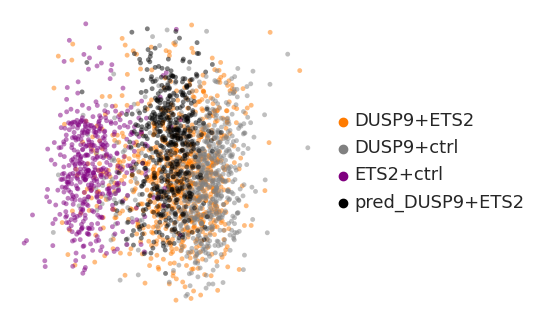

In [60]:
sc.pl.pca(story_1_umap,color=condition_key,
          palette=["#ff7b00","gray","purple","black"],
          alpha=0.5,frameon=False,title="")

In [61]:
story_1_umap_gt = story_1_umap[story_1_umap.obs[condition_key] != "pred_DUSP9+ETS2"]

In [62]:
gene_set

['GYPA',
 'HBG2',
 'GAL',
 'HBZ',
 'GYPC',
 'GYPB',
 'ALAS2',
 'FTH1',
 'PRSS57',
 'DUSP9']

saving figure to file ./figures/scvelo_heatmap_DUSP9+ETS2_t.png


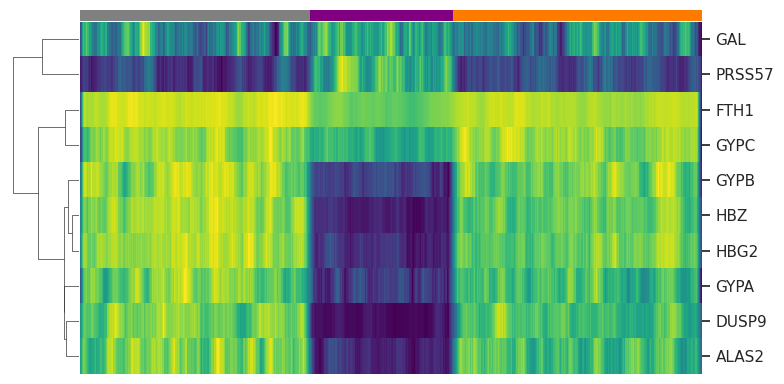

In [65]:
scl.pl.heatmap(story_1_umap_gt, var_names=gene_set, sortby="order", col_color=condition_key,
   n_convolve=30,font_scale=1,sort=True,save="DUSP9+ETS2_t.png",row_cluster=True,yticklabels=True)

In [66]:
story_1_umap_pred = story_1_umap[story_1_umap.obs[condition_key] != "DUSP9+ETS2"]

saving figure to file ./figures/scvelo_heatmap_pred_DUSP9+ETS2.png


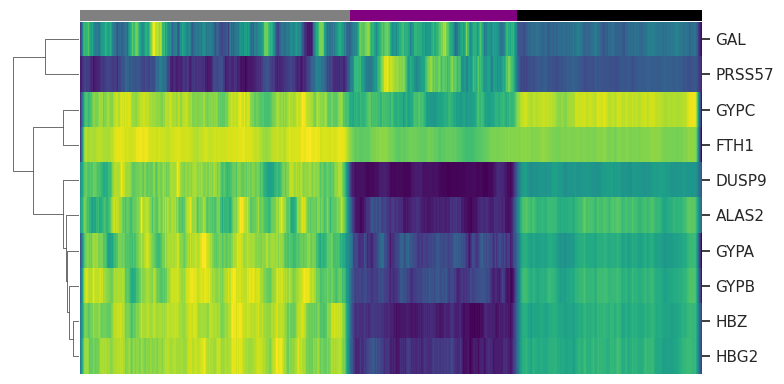

In [67]:
scl.pl.heatmap(story_1_umap_pred, var_names=gene_set, sortby="order", col_color=condition_key,
   n_convolve=30,font_scale=1,sort=True,yticklabels=True,save="pred_DUSP9+ETS2.png",row_cluster=True)